In [2]:
import pigpio
import cv2
import math
from time import sleep
import numpy as np
import math
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage
import pytesseract
import copy

In [3]:
class TLE493D:
    
    """Class of 3D Magnetic Sensor TLE493D.
    """
                                                                                                                                                      
      
    bx = 0
    by = 0
    bz = 0 
    temp = 0
    data =[]
    pi = pigpio.pi()

    addr = 0x35
    channel = 1
    
    
    h = pi.i2c_open(channel, addr)
    (count, data) = pi.i2c_read_device(h, 23)
    print(count,"             ",data)
    
    
    

    def initialize(self): 
        """ Read data from register
        """
        global data
        
        self.pi.i2c_write_byte_data(self.h, 0x11, 21)
        self.pi.i2c_write_byte_data(self.h, 0x10, 32)
        sleep(60e-6)
        (count, data) = self.pi.i2c_read_device(self.h, 23)
        print(data) 
        
    def initialize_FM(self):
        self.pi.i2c_write_byte_data(self.h, 0x11, 0x13)
        self.pi.i2c_write_byte_data(self.h, 0x10, 0x00)
        sleep(60e-6)
        
    def update_data (self):
        global data
        (count, data) = self.pi.i2c_read_device(self.h, 6)
        # print(data)
        
    def get_x(self):
        """ Get the value of X coordinate
            
            Returns:
            
            int: X coordinate
        """
        
        self.bx = (data[0] << 4) or ((data[4] >> 4) & 0x0f)
        
        if self.bx > 2047:
            
            self.bx -= 4096
        self.bx *=0.098
            
        return self.bx
    
    
    
    
    def get_y(self):
        """ Get the value of Y coordinate
            
            Returns:
            
            int: Y coordinate
        """
        self.by = data[1] << 4 or data[4] & 0x0f

        
        if self.by > 2047:
            
            self.by -= 4096
        self.by *=0.098
            
        return self.by
    
    
    
    
    def get_z(self):
        """ Get the value of Z coordinate
            
            Returns:
            
            int: Z coordinate
        """
        
        self.bz = data[2] << 4 or data[5] & 0x0f
        
        if self.bz > 2047:
            
            self.bz -= 4096
        self.bz *=0.098
            
        return self.bz
    
    
    
    def get_br(self):
        """ Calculate the radial value
            
            Returns:
            
            double : radial value
        """
        
        br = math.sqrt(self.bx*self.bx+self.by*self.by+self.bz*self.bz)
        
        return br
    
    
    
    
    def get_polar(self):
        """ Calculate the polar value
            
            Returns:
            
            double: polar value
        """
        
        polar = math.cos(math.atan2(self.bz,math.sqrt(self.bx*self.bx+self.by*self.by)))
        
        return polar
    
    
    
    
    def get_azimuth(self):
        """ Calculate the azimuthal value
            
            Returns:
            
            double: azimuthal value
        """
        
        azimuth = math.atan2(self.by,self.bx)
        
        return azimuth
  

23               bytearray(b'\x03\xf7\x02L.\xc7\xce\x80\x7f\x80\x7f\x80\x7f888 \x154\x00\xff\xff\xc9')


In [33]:
def pred(img):
    kernel = np.ones ((5,5), np.uint8)
    gray_image = 255 - img
    
    img_di = cv2.dilate(gray_image, kernel, iterations=1)

    ret,processed_img = cv2.threshold(np.array(img_di), 125, 255, cv2.THRESH_BINARY)
    config = ('-l eng --psm 13')
    h = pytesseract.image_to_string(255 - processed_img, config=config )
    return h
     

def plot(mat):
    fig = plt.figure()
    plt.polar(mat[100:,1], mat[100:,0],linewidth = 5, c= '0.15')
    plt.grid(False)
    plt.axis("off")
    plt.show()
    np_img = mplfig_to_npimage(fig)
    pred_num = pred(np_img)
    return pred_num

bytearray(b'\xf7\xf7\x0bM\xb4\x0e\xcf\x80\x7f\x80\x7f\x80\x7f888 \x154\x00\xff\xff\xc9')


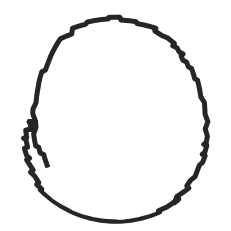

Predicted Output:  Oo.



In [34]:
mat = np.zeros((1,2),dtype=np.float64)

tle = TLE493D()
tle.initialize()

cnt = 0
while True:
    tle.update_data()
    x = tle.get_x()
    y = tle.get_y()
    z = tle.get_z()
    r = tle.get_br()
    
    theta = tle.get_polar() 
    azi = tle.get_azimuth()
    mat = np.vstack((mat, [theta, azi]))
    
    (mat_r, mat_c) = mat.shape
    sleep (200e-6)
    if ((mat_r%1000)==0):
        pred_num = plot(mat[mat_r-1000:mat_r, :])
        print("Predicted Output: ", pred_num)
        break